## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)

# Mi primera Red Neuronal Bayesiana

Las redes neuronales son modelos del estado del arte para hacer regresión y clasificación con datos complejos

Generalmente estos modelos requieren de una gran cantidad de datos para poder entrenarlos de forma efectiva y sin que se sobreajusten. Sin embargo, en algunos problemas los datos disponibles son simplemente muy escasos o muy difíciles de obtener. Adicionalmente, no es directo tomar decisiones en base al modelo, y se requiere un paso adicional de calibración. ¿Cómo podemos confiar en las decisiones del modelo?

Podemos intentar solucionar estos problemas escribiendo la red neuronal como un modelo bayesiano y aprender el posterior de sus parámetros con un método de Markov Chain Monte Carlo (siempre y cuando el modelo sea simple). 

Incorporando priors el modelo estará regularizado y en lugar de estimadores puntuales tendremos la distribución a posteriori completa. Esta rica información extra nos permite medir la confianza del modelo sobre sus predicciones (el modelo sabe cuando no sabe) facilitando la tarea de calibración. 



## Formulación clásica

En esta tarea se pide que programen un modelo de red neuronal para clasificación de datos bidimensionales, de dos clases, con una capa oculta y con función de activación sigmoidal

Sea el conjunto de datos y etiquetas

$$
\mathcal{D} = \{(x, y)^{(i)}, i=1,2,\ldots,N\} \quad x^{(i)} \in \mathbb{R}^2,  y^{(i)} \in \{0, 1\}
$$

Consideremos ahora una tupla en particular $(X, Y)$. La salida de la capa oculta en notación matricial es

$$
Z = \text{sigmoide}( W_Z X + B_Z)
$$

donde $W_Z \in \mathbb{R}^{M \times 2}$, $B_Z \in \mathbb{R}^{M}$ y  $M$ es el tamaño de la capa oculta

La salida de la capa visible (última capa) en notación matricial es

$$
Y = \text{sigmoide}( W_Y Z + B_Y)
$$

donde $W_Y \in \mathbb{R}^{1 \times M}$, $B_Z \in \mathbb{R}$

La función sigmoide se define como

$$
\text{sigmoide}(x) = \frac{1}{1+ e^{-x}}
$$

Luego $Z$ es un vector de largo $M$ con valores en $[0, 1]$ e $Y$ es un escalar con valor en el rango $[0, 1]$

## Formulación bayesiana

Para darle un toque bayesiano a este modelo debemos

- Definir priors para $W_Z$, $B_Z$, $W_Y$ y $B_Y$. Se pide que utilice priors **normales con media cero y desviación estándar diez**.
- Definir una verosimilitud para le problema. Dado que el problema es de clasificación binaria, utilice una distribución de **Bernoulli** con $p=Y$
- Considere los datos $X$ como una variable determínista. 

## Indicaciones

Utilice

- El atributo `shape` para darle la dimensión correcta a cada variable cada uno
- El atributo `observed` para asignar las etiquetas reales a esta variable aleatoria observada
- `pm.Data` para la variable independiente
- `theano.tensor.sigmoid` para calcular la función sigmoide
- `A.dot(B)` para calcular el producto matricial entre `A` y `B`



## Instrucciones específicas

- Considere el dataset sintético `two-moons` que se muestra a continuación. Se pide que realice dos experimentos variando el valor de `n_samples`, primero a $100$ y finalmente a $10$
- Implemente el modelo de red neuronal bayesiana en `pymc3` dejando $M$ como un argumento. Para cada valor de `n_samples` entrene tres modelos con $M=1$, $M=3$ y $M=10$
- Seleccione y calibre un algoritmo de MCMC para entrenar este modelo. Justifique y respalde sus decisiones en base al comportamiento de las trazas, al estadístico Gelman-Rubin y a la función de autocorrelación
- Estudie el posterior de los parámetros y evalue el posterior predictivo sobre los datos de prueba. Muestre graficamente la media y la varianza del posterior predictivo en el espacio de los datos. Haga observaciones y comparaciones entre los 6 casos (3 valores de $M$ y 2 valores de `n_samples`)

# Solución

In [1]:
import pymc3 as pm
import theano
from theano.tensor.nnet import sigmoid

## Implementación del modelo (n_samples = 100)

<IPython.core.display.Javascript object>


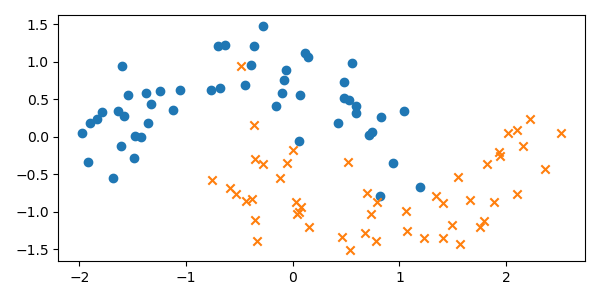

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=100, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.scatter(x[y==0, 0], x[y==0, 1], marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], marker='x')

x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), 
                     np.linspace(-3, 3, 100))
x_test100 = np.vstack([x1.ravel(), x2.ravel()]).T

In [3]:
def modelrnb(M):
    with pm.Model() as bayes_reg:
        #datos de entrada
        X_shared = pm.Data("x", x).T
        Y_shared = pm.Data("y", y)
        #prioris
        wz = pm.Normal(name='wz', mu=0, sd =10, shape=(M,2))
        bz = pm.Normal(name='bz', mu=0, sd =10, shape=(M,1))
        wy = pm.Normal(name='wy', mu=0, sd =10, shape=(1,M))
        by = pm.Normal(name='by', mu=0, sd =10, shape=(1,1))
        #variable determinista 
        X = pm.Deterministic('X', X_shared)  
        #verosimilitud
        Z = sigmoid(wz.dot(X)+bz)
        Y = sigmoid(wy.dot(Z)+by)
        Y_obs = pm.Bernoulli('Y_obs', p=Y, observed=y)
    return bayes_reg

### Modelo 1 (M = 1)

In [4]:
a100 = modelrnb(1)
a100

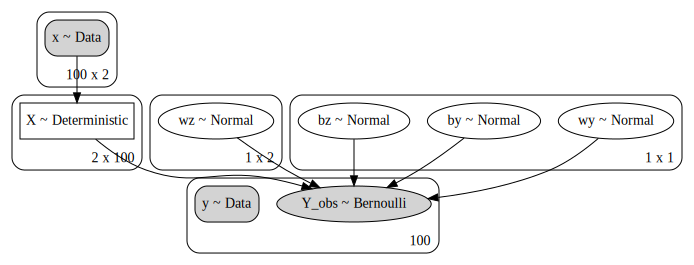

In [5]:
pm.model_to_graphviz(a100)

### Modelo 2 (M = 3)

In [6]:
b100 = modelrnb(3)
b100

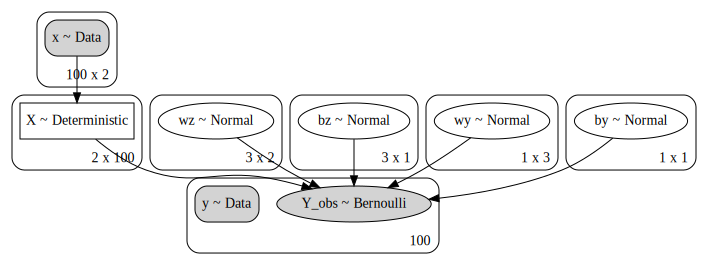

In [7]:
pm.model_to_graphviz(b100)

### Modelo 3 (M = 10)

In [8]:
c100 = modelrnb(10)
c100

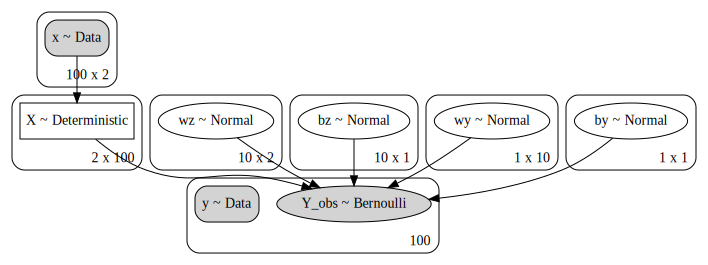

In [9]:
pm.model_to_graphviz(c100)

## Implementación del modelo (n_samples = 10)

<IPython.core.display.Javascript object>


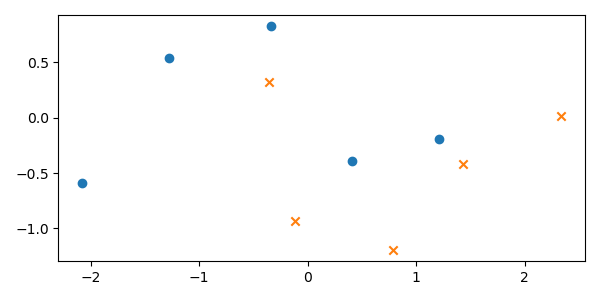

In [158]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=10, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.scatter(x[y==0, 0], x[y==0, 1], marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], marker='x')

x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), 
                     np.linspace(-3, 3, 100))
x_test10 = np.vstack([x1.ravel(), x2.ravel()]).T

### Modelo 1 (M = 1)

In [159]:
a10 = modelrnb(1)
a10

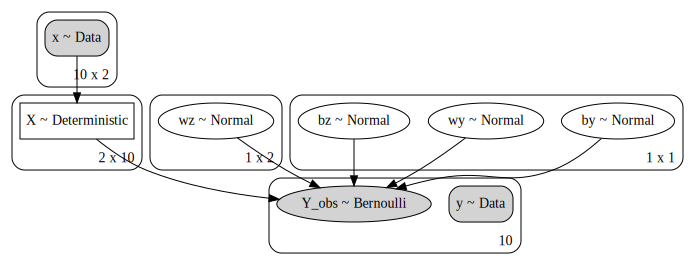

In [160]:
pm.model_to_graphviz(a10)

### Modelo 2 (M = 3)

In [161]:
b10 = modelrnb(3)
b10

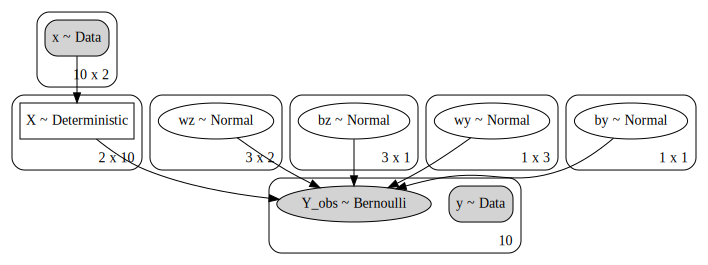

In [162]:
pm.model_to_graphviz(b10)

### Modelo 3 (M = 10)

In [163]:
c10 = modelrnb(10)
c10

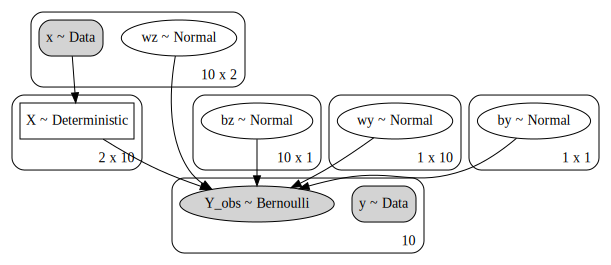

In [164]:
pm.model_to_graphviz(c10)

## Selección y calibración de un algoritmo de MCMC para entrenar este modelo.

### Modelo 1 (100 samples)

#### Entrenamiento Algoritmo MCMC

In [24]:
with a100:
    trace = pm.sample(draws=3000,
                      tune=500,
                      chains=2,
                      cores=4,
                      step=pm.NUTS())


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [by, wy, bz, wz]
Sampling 2 chains, 0 divergences:   0%|                                                    | 0/7000 [00:00<?, ?draws/s]


RuntimeError: Chain 0 failed.

####  Trazas

<IPython.core.display.Javascript object>


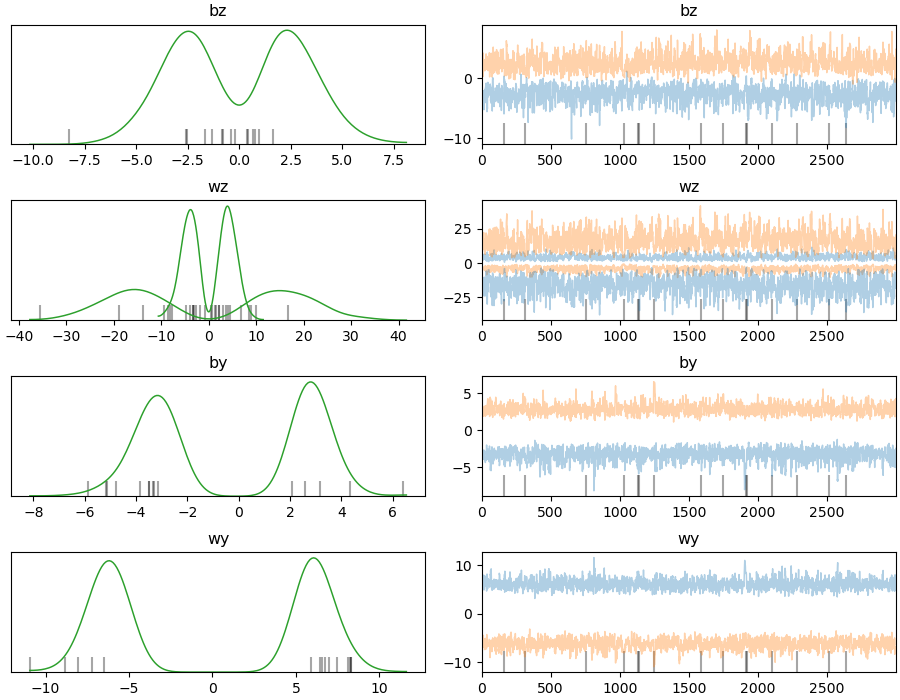

D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

In [11]:
pm.traceplot(trace, figsize=(9, 7), var_names=['bz', 'wz', 'by','wy'], combined=True);

#### Valor de $\hat{r}$

In [12]:
pm.summary(trace, var_names=['bz', 'wz', 'by','wy']).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"bz[0,0]",-0.011,3.006,-4.953,4.927,1.938,1.582,2.0,2.0,3.0,64.0,1.83
"wz[0,0]",-0.003,4.631,-7.246,7.197,3.074,2.537,2.0,2.0,3.0,59.0,1.83
"wz[0,1]",0.018,17.679,-27.210,26.409,11.821,9.785,2.0,2.0,3.0,52.0,1.83
"by[0,0]",-0.229,3.204,-4.516,4.212,2.209,1.852,2.0,2.0,3.0,77.0,1.83
"wy[0,0]",-0.035,6.316,-8.146,7.782,4.410,3.717,2.0,2.0,3.0,75.0,1.83


#### Autocorrelación

<IPython.core.display.Javascript object>


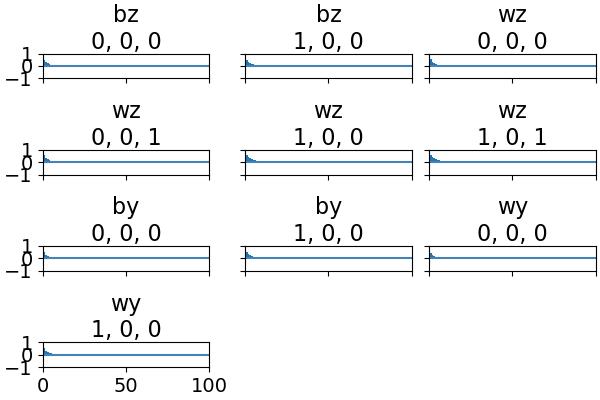

In [13]:
pm.plots.autocorrplot(trace, figsize=(6, 4), 
                      var_names=['bz', 'wz', 'by','wy']);

### Modelo 2 (100 samples)

####  Entrenamiento Algoritmo MCMC

In [14]:
with b100:
    trace = pm.sample(draws=3000,
                      tune=500,
                      chains=2,
                      cores=4,
                      step=pm.NUTS())

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [by, wy, bz, wz]
Sampling 2 chains, 202 divergences: 100%|██████████████████████████████████████| 7000/7000 [00:56<00:00, 124.37draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6816958769810115, but should be close to 0.8. Try to increase the number of tuning steps.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.681335813529331, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


#### Trazas

<IPython.core.display.Javascript object>


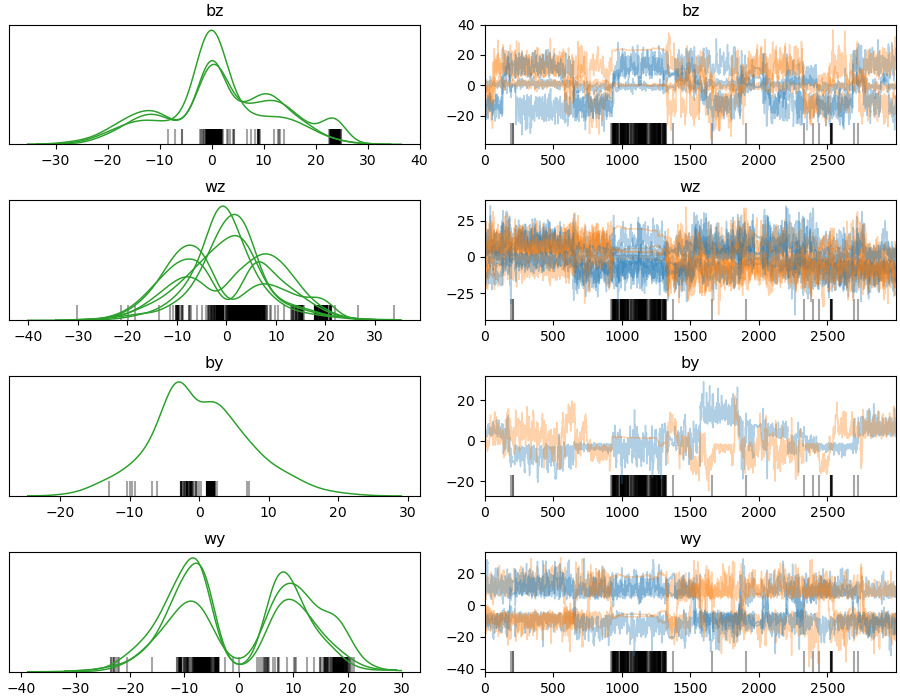

D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

In [15]:
pm.traceplot(trace, figsize=(9, 7), var_names=['bz', 'wz', 'by','wy'], combined=True);

#### Valor de $\hat{r}$

In [16]:
pm.summary(trace, var_names=['bz', 'wz', 'by','wy']).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"bz[0,0]",0.808,11.067,-20.067,19.549,2.010,1.435,30.0,30.0,32.0,296.0,1.06
"bz[1,0]",0.441,9.868,-19.108,19.650,2.541,1.832,15.0,15.0,14.0,66.0,1.09
"bz[2,0]",3.148,11.485,-15.827,24.557,3.914,2.868,9.0,9.0,9.0,16.0,1.18
"wz[0,0]",2.053,10.328,-16.767,18.948,3.955,2.926,7.0,7.0,8.0,70.0,1.17
"wz[0,1]",-0.207,7.107,-13.647,15.514,1.369,0.979,27.0,27.0,24.0,142.0,1.05
"wz[1,0]",-1.388,11.023,-16.641,20.285,2.442,1.752,20.0,20.0,24.0,40.0,1.03
"wz[1,1]",-0.592,8.529,-18.464,15.176,2.681,1.953,10.0,10.0,9.0,104.0,1.18
"wz[2,0]",-0.898,10.687,-18.301,18.200,2.420,1.737,20.0,20.0,25.0,197.0,1.09
"wz[2,1]",1.049,7.701,-13.387,18.627,3.248,2.428,6.0,6.0,5.0,29.0,1.30
"by[0,0]",0.235,7.083,-13.597,13.776,1.998,1.447,13.0,13.0,13.0,45.0,1.11


#### Autocorrelación

<IPython.core.display.Javascript object>


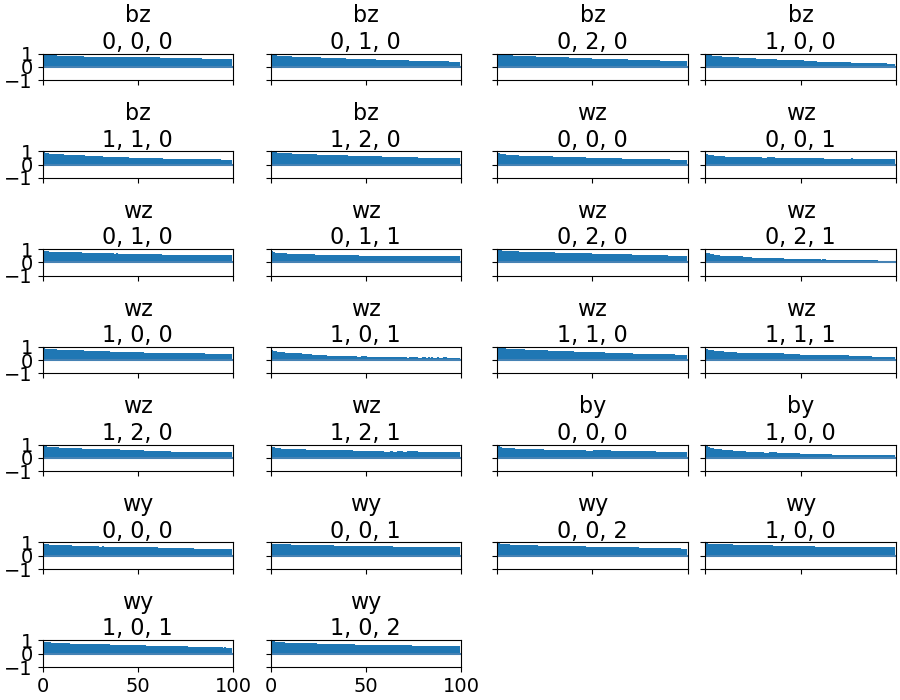

In [17]:
pm.plots.autocorrplot(trace, figsize=(9, 7), 
                      var_names=['bz', 'wz', 'by','wy']);

### Modelo 3 (100 samples)

In [18]:
with c100:
    trace = pm.sample(draws=3000,
                      tune=500,
                      chains=2,
                      cores=4,
                      step=pm.NUTS())

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [by, wy, bz, wz]
Sampling 2 chains, 2 divergences: 100%|█████████████████████████████████████████| 7000/7000 [03:29<00:00, 33.39draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


#### Trazas 

<IPython.core.display.Javascript object>


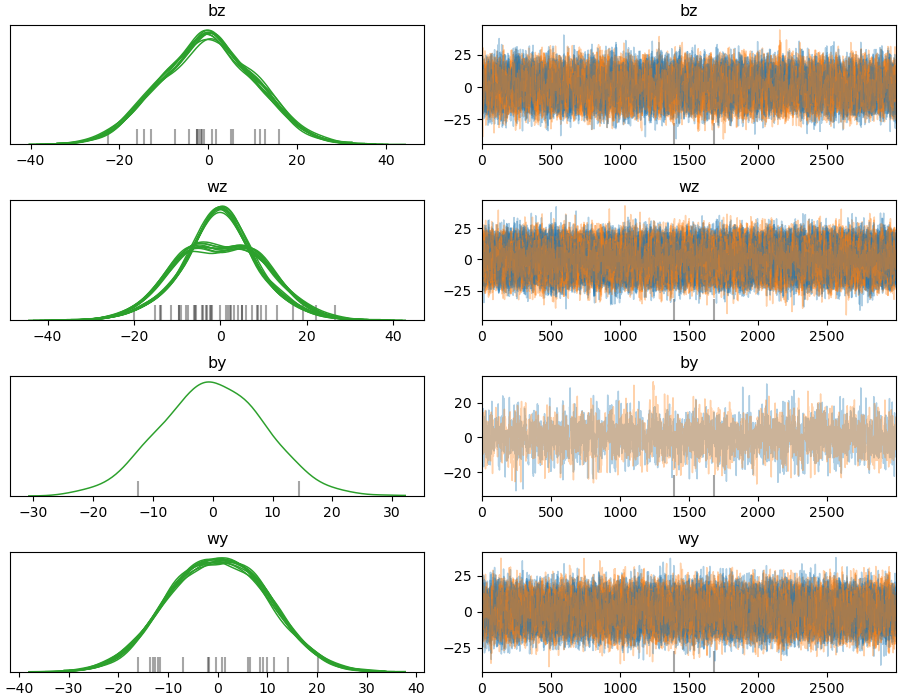

D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

In [19]:
pm.traceplot(trace, figsize=(9, 7), var_names=['bz', 'wz', 'by','wy'], combined=True);

#### Valor de $\hat{r}$

In [20]:
pm.summary(trace, var_names=['bz', 'wz', 'by','wy']).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"bz[0,0]",0.153,10.543,-19.591,19.781,0.324,0.229,1057.0,1057.0,1067.0,2784.0,1.00
"bz[1,0]",0.587,10.767,-18.890,20.527,0.351,0.248,942.0,942.0,961.0,2972.0,1.00
"bz[2,0]",-0.350,10.694,-20.840,19.104,0.335,0.237,1016.0,1016.0,1026.0,2708.0,1.00
"bz[3,0]",-0.251,10.481,-19.527,19.571,0.322,0.228,1061.0,1061.0,1070.0,2879.0,1.00
"bz[4,0]",0.182,10.511,-19.825,18.994,0.316,0.223,1108.0,1108.0,1124.0,2988.0,1.00
"bz[5,0]",-0.202,10.201,-18.638,19.306,0.306,0.216,1114.0,1114.0,1126.0,2644.0,1.00
"bz[6,0]",-0.116,10.364,-19.676,18.382,0.334,0.236,963.0,963.0,970.0,2896.0,1.00
"bz[7,0]",0.053,10.465,-18.550,19.471,0.390,0.276,720.0,720.0,725.0,2261.0,1.01
"bz[8,0]",-0.467,10.557,-20.143,18.913,0.341,0.241,959.0,959.0,971.0,2950.0,1.00
"bz[9,0]",0.186,10.457,-19.454,19.248,0.320,0.226,1069.0,1069.0,1081.0,2952.0,1.00


#### Autocorrelación 

D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\plot_utils.py:624: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (82) in plot_autocorr, generating only 40 plots
  warnings.warn(


<IPython.core.display.Javascript object>


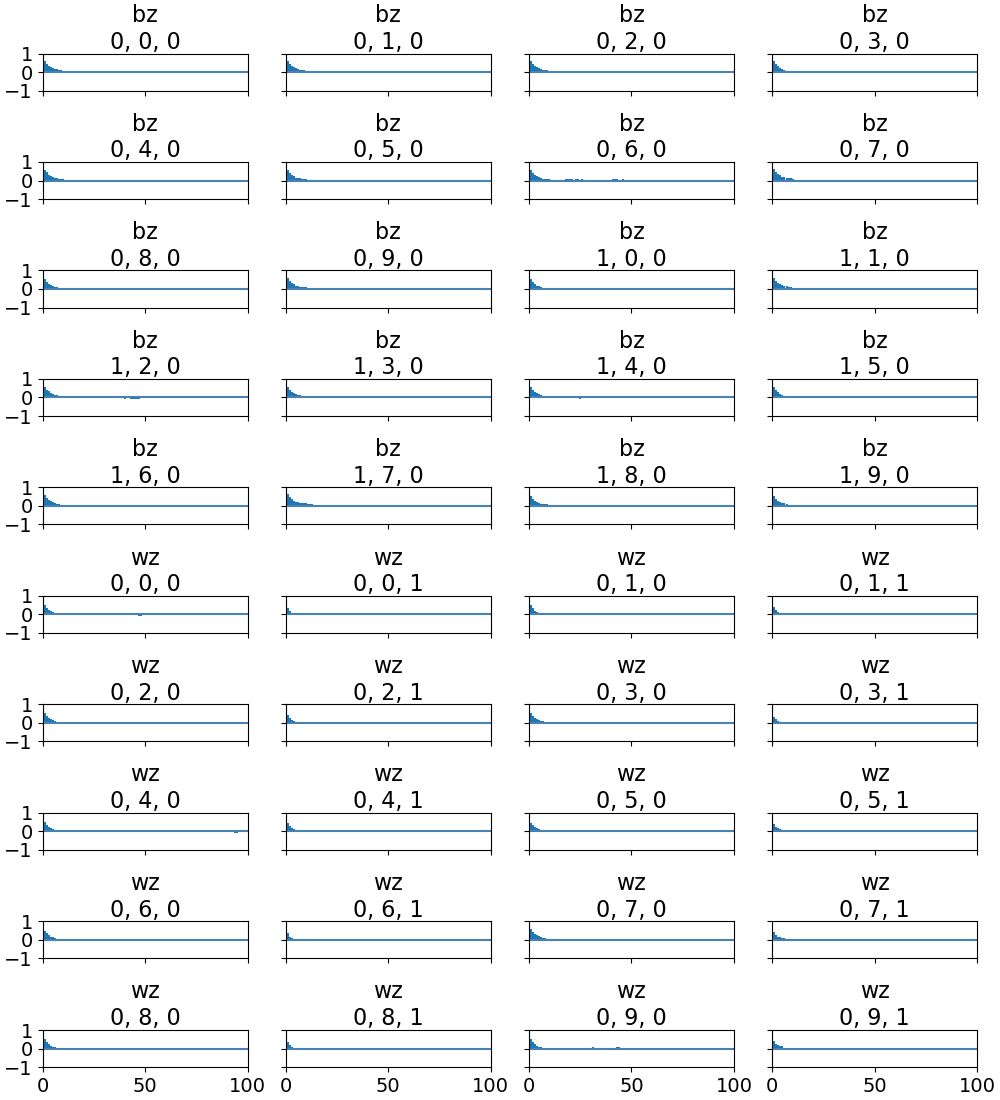

In [21]:
pm.plots.autocorrplot(trace, figsize=(10, 11), 
                      var_names=['bz', 'wz', 'by','wy']);

## Estudio de Posteriors

### Modelo 1 (100 samples)

#### Posterior Parámetros

D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\plot_utils.py:624: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (41) in plot_posterior, generating only 40 plots
  warnings.warn(


<IPython.core.display.Javascript object>


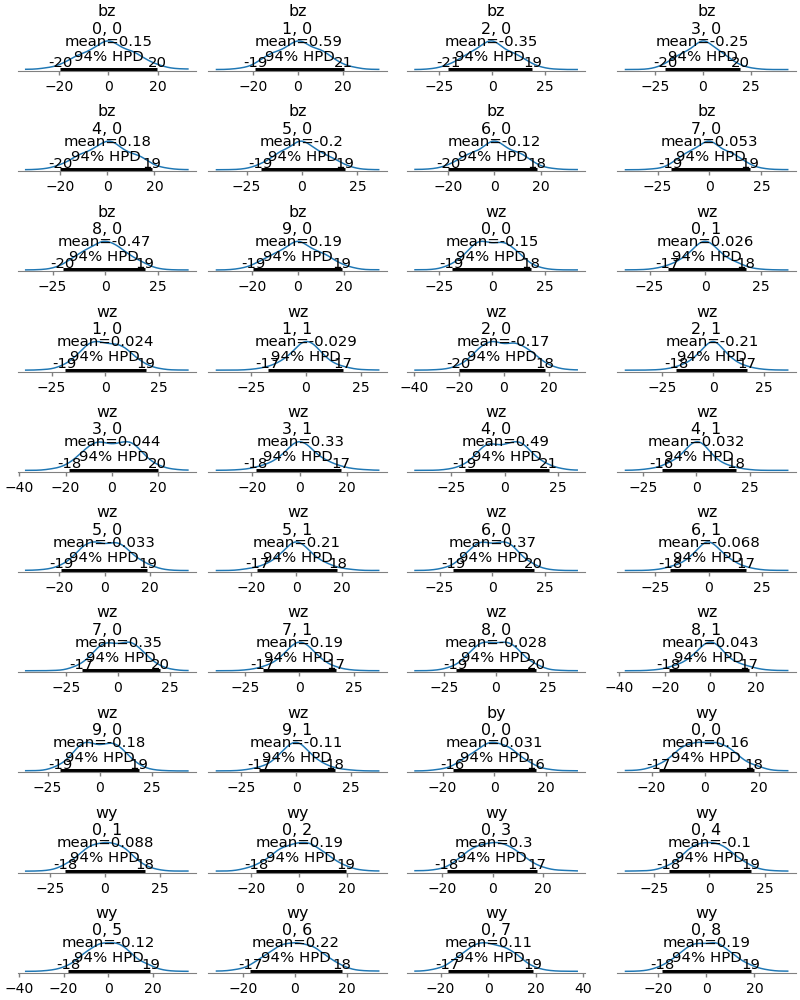

In [25]:
with a100:
    pm.plot_posterior(trace, figsize=(8, 10), var_names=['bz', 'wz', 'by','wy'], textsize=10);

#### Posterior Predictiva

In [26]:
with a100:
    pm.set_data({"x": x_test100})
    posterior_predictive = pm.sample_posterior_predictive(trace, samples=50, var_names=["X", "Y_obs"])

D:\Users\Javi\miniconda3\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


TypeError: ('Bad input argument to theano function with name "D:\\Users\\Javi\\miniconda3\\lib\\site-packages\\pymc3\\distributions\\distribution.py:692" at index 0 (0-based). ', 'Non-unit value on shape on a broadcastable dimension.', (1, 10), (True, True))

<IPython.core.display.Javascript object>


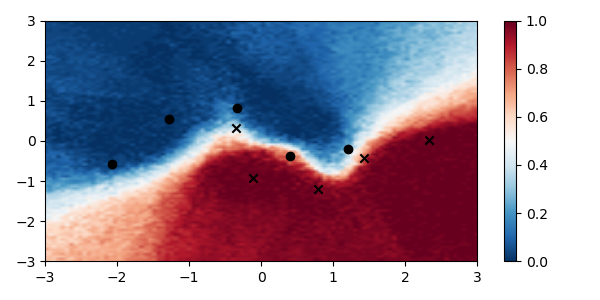

In [181]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
cmap = ax.pcolormesh(x1, x2, np.mean(posterior_predictive['Y_obs'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
plt.colorbar(cmap, ax=ax)
ax.scatter(x[y==0, 0], x[y==0, 1], c='k', marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], c='k', marker='x')

### Modelo 2 (100 samples)

#### Posterior Parámetros

D:\Users\Javi\miniconda3\lib\site-packages\arviz\plots\plot_utils.py:624: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (41) in plot_posterior, generating only 40 plots
  warnings.warn(


<IPython.core.display.Javascript object>


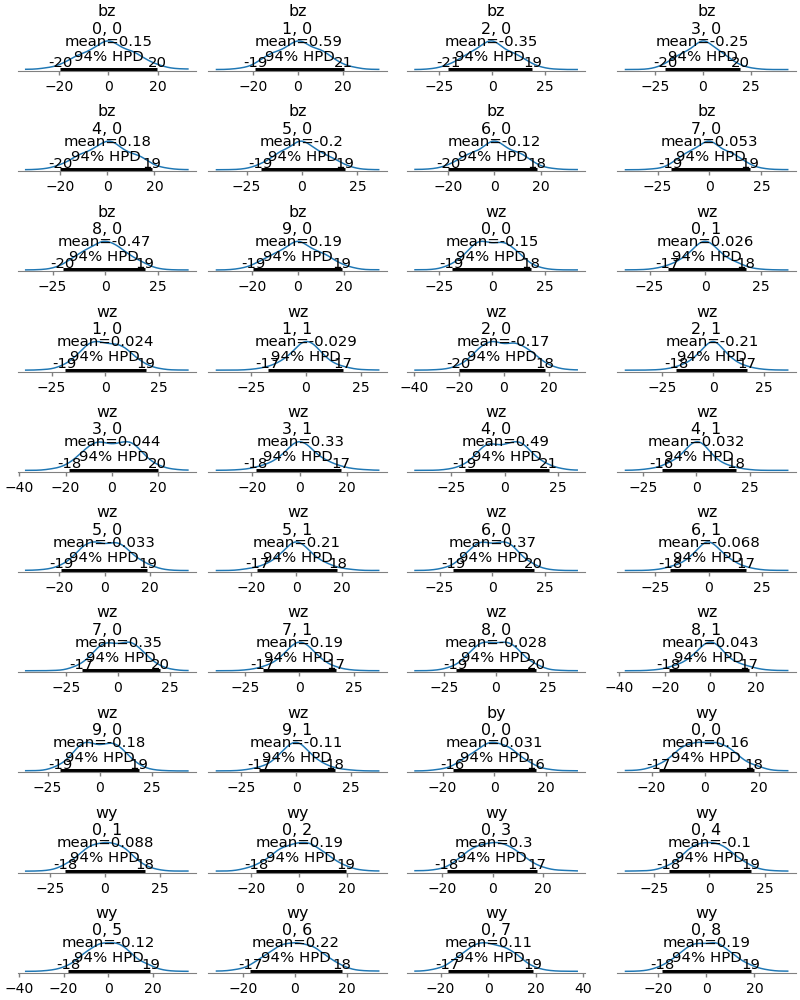

In [27]:
with b100:
    pm.plot_posterior(trace, figsize=(8, 10), var_names=['bz', 'wz', 'by','wy'], textsize=10);

#### Posterior Predictiva

In [185]:
with b100:
    pm.set_data({"x": x_test100})
    posterior_predictive = pm.sample_posterior_predictive(trace, samples=50, var_names=["X", "Y_obs"])

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 100.18it/s]


<IPython.core.display.Javascript object>


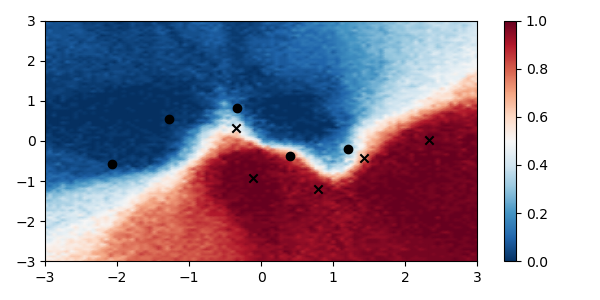

In [186]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
cmap = ax.pcolormesh(x1, x2, np.mean(posterior_predictive['Y_obs'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
plt.colorbar(cmap, ax=ax)
ax.scatter(x[y==0, 0], x[y==0, 1], c='k', marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], c='k', marker='x')

### Modelo 3 (100 samples)

#### Posterior Parámetros

<IPython.core.display.Javascript object>


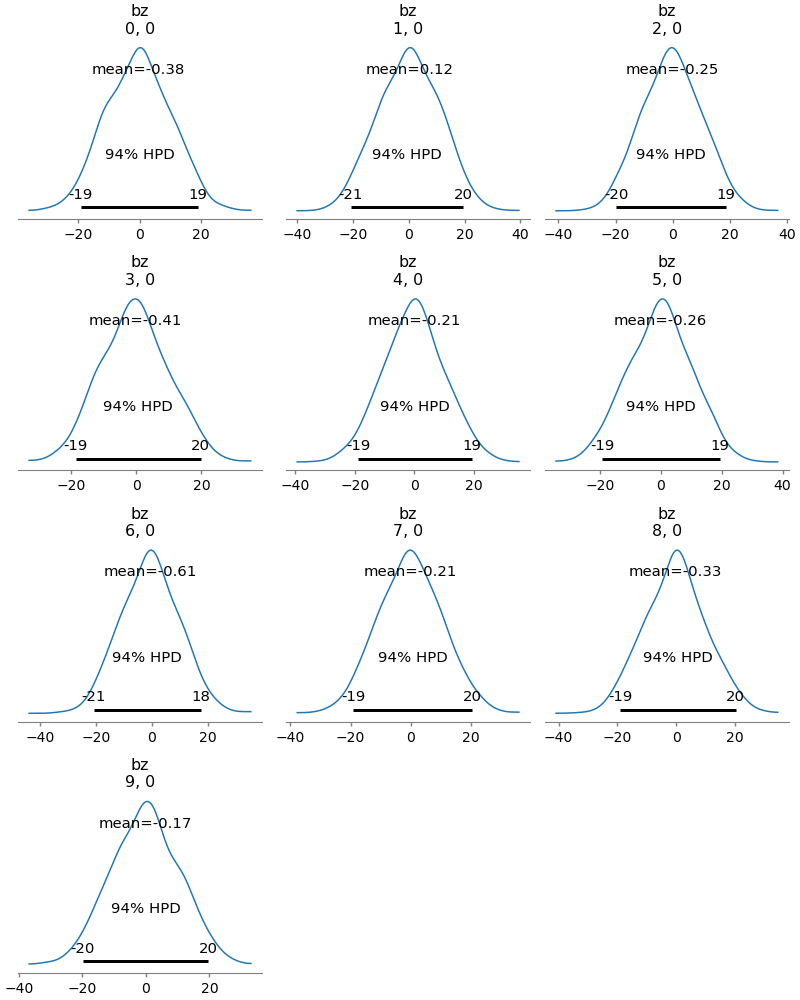

In [187]:
with c100:
    pm.plot_posterior(trace, figsize=(8, 10), var_names=['bz'], textsize=10);

#### Posterior Predictiva

In [188]:
with c100:
    pm.set_data({"x": x_test100})
    posterior_predictive = pm.sample_posterior_predictive(trace, samples=50, var_names=["X", "Y_obs"])

D:\Users\Javi\miniconda3\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 93.61it/s]


<IPython.core.display.Javascript object>


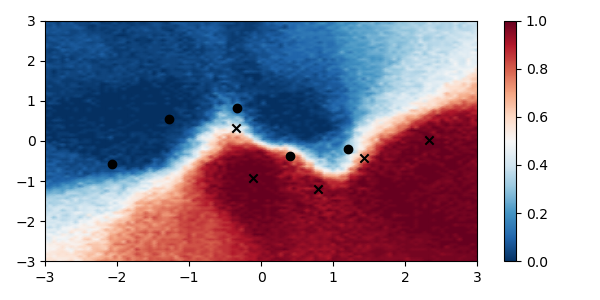

In [189]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
cmap = ax.pcolormesh(x1, x2, np.mean(posterior_predictive['Y_obs'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
plt.colorbar(cmap, ax=ax)
ax.scatter(x[y==0, 0], x[y==0, 1], c='k', marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], c='k', marker='x')